In [1]:
 import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['axes.titlesize'] = 15 
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15  
plt.rcParams['ytick.labelsize'] = 15  

### Z and mag filters :

In [4]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<28','mag_i>18',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

### CosmoDC2 and DC2Objects (truth and object) :

In [5]:
import GCRCatalogs
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [6]:
cosmodc2.get_quantity_info('is_central')

In [7]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [8]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [9]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters, 
                                      native_filters=healpix_filter))

In [10]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 2920943
nombre de galaxies centrales = 2669420
pourcentage de galaxies centrales = 91.38897951791596 %
nombre d'objets = 676713


### FoF algo :

In [11]:
my_linking_length = 0.4 #linking_lenghts in arcseconds optimal, for 18<mag<26.5

In [12]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                  linking_lengths=my_linking_length)

In [13]:
# first we need to know which rows are from the truth catalog and which are from the object

truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

In [14]:
# np.bincount will give up the number of id occurrences (like histogram but with integer input)

n_groups = results['group_id'].max() + 1   #nombre de groupes total (groupe/objet)
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)  # groupe d'objets

print(results['group_id'].max())

2852652


In [15]:
print('total nbr of groups = ', n_groups)
print('nbr of group with at list 1 galaxies = ', len(n_truth[n_truth>0]), "(", (len(n_truth[n_truth>0])/n_groups)*100, '%)')
print('nbr of group with at list 1 object =', len(n_object[n_object>0]), "(", (len(n_object[n_object>0])/n_groups)*100, '%)')

total nbr of groups =  2852653
nbr of group with at list 1 galaxies =  2822154 ( 98.9308548919199 %)
nbr of group with at list 1 object = 676675 ( 23.72090121020678 %)


#### Galaxy central selection :

In [16]:
ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)

In [17]:
ind_galax_central = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)

In [18]:
n_truth_central=np.bincount(results[truth_mask][ind_galax_central]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

In [19]:
print('nbr of group with at list 1 central galaxies = ', len(n_truth_central[n_truth_central>0]), "(", (len(n_truth[n_truth_central>0])/n_groups)*100, '%)')

nbr of group with at list 1 central galaxies =  2589936 ( 90.7904326253491 %)


Normalised histogram. When we remove satellite galaxies, we can observe a small increase in unrelated object.  

### Satellite galaxies selection :

In [20]:
ind_galax_sat = ~ind_galax_central  #donne indices des galaxies satellites dans l'ordre de results (par groupe_id)

# Halo_mass + z max cut :

In [21]:
truth_data_halo_mass= truth_data['halo_mass'][ind_galax]

truth_data_z= truth_data['redshift'][ind_galax]

In [22]:
halo_mass_cut_13=np.array([1e13, 5*1e13, 1e14])

z_max_cut= 1.5

## Halo_mass <1e13 + z-max-cut study for all galaxies in the field :

In [23]:
n_truth_2cut_all = np.bincount(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]['group_id'],
                               minlength=n_groups)

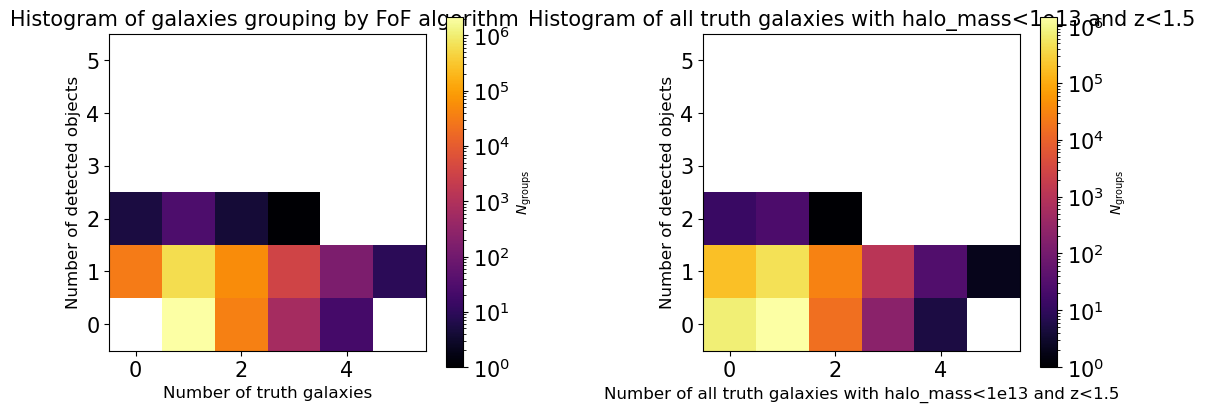

In [24]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_all=plt.hist2d(n_truth_2cut_all, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all truth galaxies with halo_mass<1e13 and z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all truth galaxies with halo_mass<1e13 and z<1.5')

plt.show()

In [25]:
print("missed detections :")

print("nbr of (1-0) systems for all truth galaxies with z>1,5 and halo_mass>1e13=", hist2d2_2cut_all[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_all[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_all[0][2,1])

missed detections :
nbr of (1-0) systems for all truth galaxies with z>1,5 and halo_mass>1e13= 1443870.0
recognized blending :
nbr of (1-1) systems = 469347.0
unrecognized blending :
nbr of (2-1) systems = 28587.0


In [26]:
print("% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,0]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]))*100)

print("% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]))*100)

print("% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][2,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]))*100)

% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 71.97243666079636
% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 23.39549075016088
% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 1.4249731948320732


## Halo_mass >1e13 + z-max-cut study for central galaxies in the field :

In [27]:
n_truth_2cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]]['group_id'],
                               minlength=n_groups)

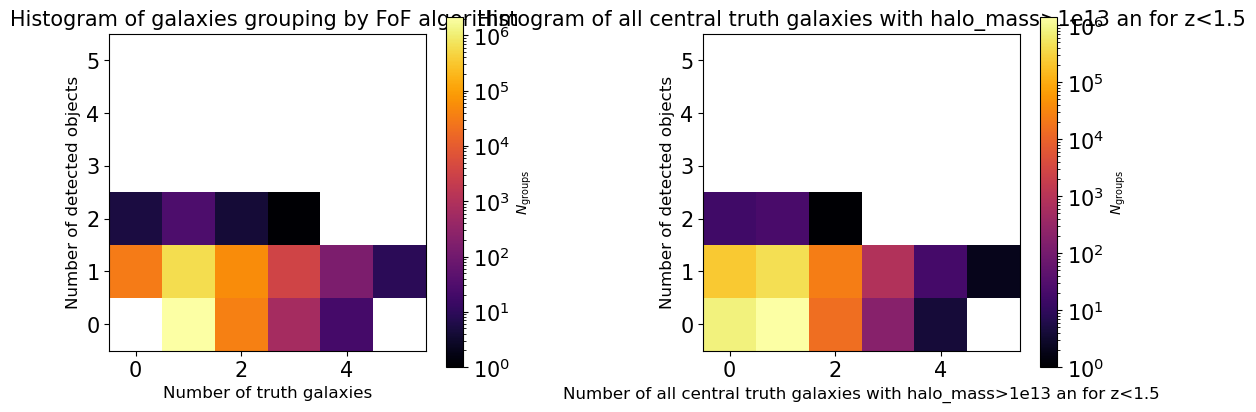

In [28]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_central=plt.hist2d(n_truth_2cut_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all central truth galaxies with halo_mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all central truth galaxies with halo_mass>1e13 an for z<1.5')

plt.show()

In [29]:
print("missed detections :")

print("nbr of (1-0) systems for all central truth galaxies with z>1,5 and halo_mass >1e13 =", hist2d2_2cut_central[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_central[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_central[0][2,1])

missed detections :
nbr of (1-0) systems for all central truth galaxies with z>1,5 and halo_mass >1e13 = 1386165.0
recognized blending :
nbr of (1-1) systems = 417380.0
unrecognized blending :
nbr of (2-1) systems = 23478.0


In [30]:
print("% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,0]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]]))*100)

print("% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]]))*100)

print("% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][2,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]]))*100)

% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 73.62866990714649
% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 22.16989625754856
% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 1.2470765832927433


## Halo_mass >1e13 + z-max-cut study for sat galaxies in the field :

In [31]:
n_truth_2cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]<halo_mass_cut_13[0]))[0]]['group_id'],
                               minlength=n_groups)

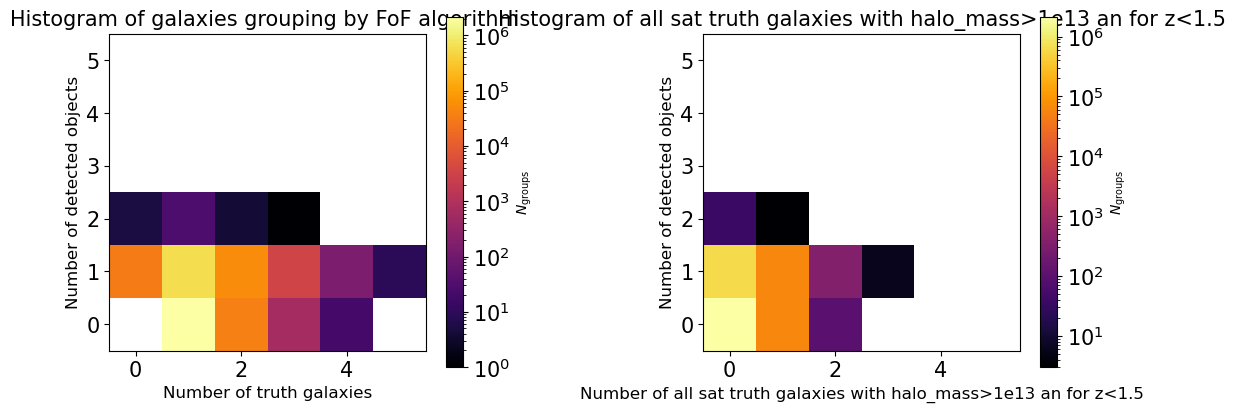

In [32]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_sat=plt.hist2d(n_truth_2cut_sat, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all sat truth galaxies with halo_mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all sat truth galaxies with halo_mass>1e13 an for z<1.5')

plt.show()

In [33]:
print("missed detections :")

print("nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 =", hist2d2_2cut_sat[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_sat[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_sat[0][2,1])

missed detections :
nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 = 60267.0
recognized blending :
nbr of (1-1) systems = 62284.0
unrecognized blending :
nbr of (2-1) systems = 368.0


In [34]:
print("% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,0]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]<halo_mass_cut_13[0]))[0]]))*100)

print("% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]<halo_mass_cut_13[0]))[0]]))*100)

print("% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][2,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]<halo_mass_cut_13[0]))[0]]))*100)

% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 48.79919028340081
% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 50.43238866396761
% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 0.2979757085020243


# (1-0) system study for galaxies in the field :

In [35]:
##### cut et différents objets utiles :

# galaxy central selection :

ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)
ind_galax_central = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)
n_truth_central=np.bincount(results[truth_mask][ind_galax_central]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

####################################################################################

truth_data_halo_mass= truth_data['halo_mass'][ind_galax]
truth_data_z= truth_data['redshift'][ind_galax]
truth_data_i_mag= truth_data['mag_i'][ind_galax]

#cut :

halo_mass_cut_13=np.array([1e13, 5*1e13, 1e14])
z_max_cut= 1.5

In [36]:
#selection indice des galaxies présentes dans les systèmes 1-0 :

system_1_0_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 0)))
system_1_0_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 1) & (n_object == 0)))
system_1_0_mask_sat= np.in1d(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]<halo_mass_cut_13[0]))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_sat == 1) & (n_object == 0)))

ind_truth_all_1_0=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]][system_1_0_mask_all]['row_index']
ind_truth_central_1_0=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]][system_1_0_mask_central]['row_index']
ind_truth_sat_1_0=results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]<halo_mass_cut_13[0]))[0]][system_1_0_mask_sat]['row_index']

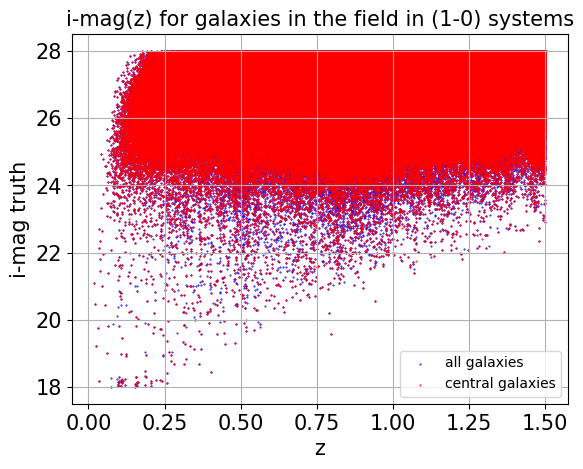

In [37]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_1_0], truth_data['mag_i'][ind_truth_all_1_0], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_1_0], truth_data['mag_i'][ind_truth_central_1_0], s=0.2, label='central galaxies', color='red')
plt.xlabel('z', fontsize=15)
plt.ylabel('i-mag truth', fontsize=15)
plt.title('i-mag(z) for galaxies in the field in (1-0) systems', fontsize=15)
plt.legend()
plt.grid()
plt.savefig('(1-0)_system_study_for_galaxy_out_clusters_plot/i-mag(z) for galaxies in the field in (1-0) systems')
plt.show()

La plupart des galaxies centrales pas detectées => graphe halo mass dit que galaxies sat des groupes + brillantes que dans les amas (distribution de lumière plus uniforme).

In [38]:
print("% of missed detection in clusters for glaxies outside clusters with a mass>1e13 and at z<1,5 =", (len(ind_truth_all_1_0)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]))*100)

% of missed detection in clusters for glaxies outside clusters with a mass>1e13 and at z<1,5 = 71.97243666079636


In [39]:
#Coordinates of the truth and detected objects :

truth_sc_1_0_all = SkyCoord(truth_data['ra'][ind_truth_all_1_0], truth_data['dec'][ind_truth_all_1_0], unit="deg")

ra_truth_1_0_all = truth_sc_1_0_all.ra
dec_truth_1_0_all = truth_sc_1_0_all.dec

#########

truth_sc_1_0_central = SkyCoord(truth_data['ra'][ind_truth_central_1_0], truth_data['dec'][ind_truth_central_1_0], unit="deg")


ra_truth_1_0_central = truth_sc_1_0_central.ra
dec_truth_1_0_central = truth_sc_1_0_central.dec

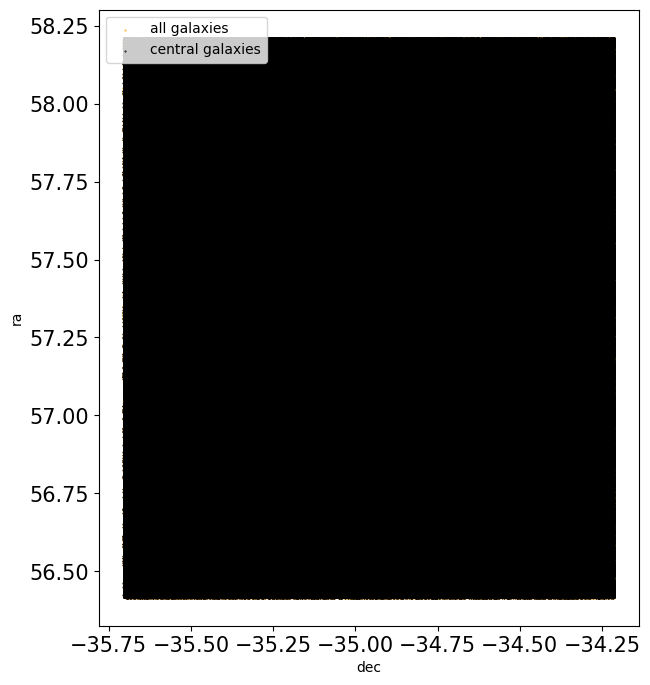

In [40]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
plt.scatter(dec_truth_1_0_all, ra_truth_1_0_all, s=0.2, label='all galaxies', color='orange')
plt.scatter(dec_truth_1_0_central, ra_truth_1_0_central, s=0.2, label='central galaxies', color='black')
plt.legend()
plt.xlabel('dec')
plt.ylabel('ra')

plt.show()

We cannot say anything with just the plot of ra, dec coordonate.

#### Fraction below i-mag = 24 (mag lim) :

In [41]:
n_truth_3cut_all = np.bincount(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0])  & (truth_data_i_mag < 24))[0]]['group_id'],
                               minlength=n_groups)

n_truth_3cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0])  & (truth_data_i_mag[ind_galax_central] < 24))[0]]['group_id'],
                               minlength=n_groups)

n_truth_3cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]<halo_mass_cut_13[0])  & (truth_data_i_mag[ind_galax_sat] < 24))[0]]['group_id'],
                               minlength=n_groups)

In [42]:
#selection indice des galaxies présentes dans les systèmes 1-0 :

system_1_0_mask_all_i_mag_24= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]) & (truth_data_i_mag < 24))[0]]['group_id'],
                             np.flatnonzero((n_truth_3cut_all == 1) & (n_object == 0)))

system_1_0_mask_central_i_mag_24= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]) & (truth_data_i_mag[ind_galax_central] < 24))[0]]['group_id'],
                                 np.flatnonzero((n_truth_3cut_central == 1) & (n_object == 0)))

system_1_0_mask_sat_i_mag_24= np.in1d(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]<halo_mass_cut_13[0]) & (truth_data_i_mag[ind_galax_sat] < 24))[0]]['group_id'],
                                 np.flatnonzero((n_truth_3cut_sat == 1) & (n_object == 0)))

ind_truth_all_1_0_i_mag_24=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]) & (truth_data_i_mag < 24))[0]][system_1_0_mask_all_i_mag_24]['row_index']

ind_truth_central_1_0_i_mag_24=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]) & (truth_data_i_mag[ind_galax_central] < 24))[0]][system_1_0_mask_central_i_mag_24]['row_index']

ind_truth_sat_1_0_i_mag_24=results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]<halo_mass_cut_13[0]) & (truth_data_i_mag[ind_galax_sat] < 24))[0]][system_1_0_mask_sat_i_mag_24]['row_index']

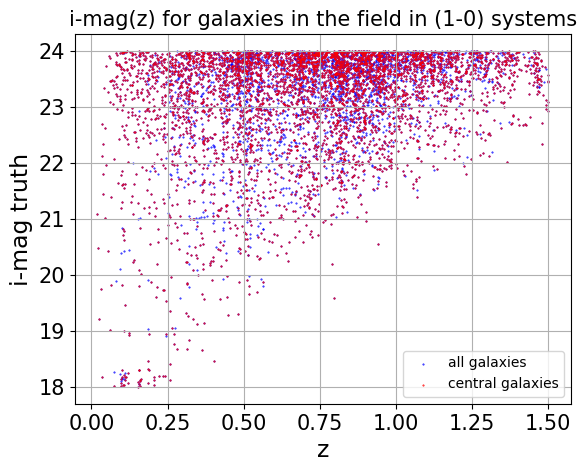

In [43]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_1_0_i_mag_24], truth_data['mag_i'][ind_truth_all_1_0_i_mag_24], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_1_0_i_mag_24], truth_data['mag_i'][ind_truth_central_1_0_i_mag_24], s=0.2, label='central galaxies', color='red')
plt.xlabel('z', fontsize=17)
plt.ylabel('i-mag truth', fontsize=17)
plt.title('i-mag(z) for galaxies in the field in (1-0) systems', fontsize=15)
plt.legend()
plt.grid()
plt.savefig('(1-0)_system_study_for_galaxy_out_clusters_plot/Magnitude truth as a function of redshift for galaxies that are not belonging in cluster with halo_mass>1e13 in (1-0) systems and with i-mag <= 24')
plt.show()

In [44]:
print("% of missed detection in cluster with a mass >1e13, z<1,5 and i-mag limit = 24 is : ", (len(ind_truth_all_1_0_i_mag_24)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut_13[0]) & (truth_data_i_mag < 24))[0]]))*100)

% of missed detection in cluster with a mass >1e13, z<1,5 and i-mag limit = 24 is :  54.25847648169799


In [45]:
#Coordinates of the truth and detected objects :

truth_sc_1_0_all_i_mag_24 = SkyCoord(truth_data['ra'][ind_truth_all_1_0_i_mag_24], truth_data['dec'][ind_truth_all_1_0_i_mag_24], unit="deg")

ra_truth_1_0_all_i_mag_24 = truth_sc_1_0_all_i_mag_24.ra
dec_truth_1_0_all_i_mag_24 = truth_sc_1_0_all_i_mag_24.dec

#########

truth_sc_1_0_central_i_mag_24 = SkyCoord(truth_data['ra'][ind_truth_central_1_0_i_mag_24], truth_data['dec'][ind_truth_central_1_0_i_mag_24], unit="deg")


ra_truth_1_0_central_i_mag_24 = truth_sc_1_0_central_i_mag_24.ra
dec_truth_1_0_central_i_mag_24 = truth_sc_1_0_central_i_mag_24.dec

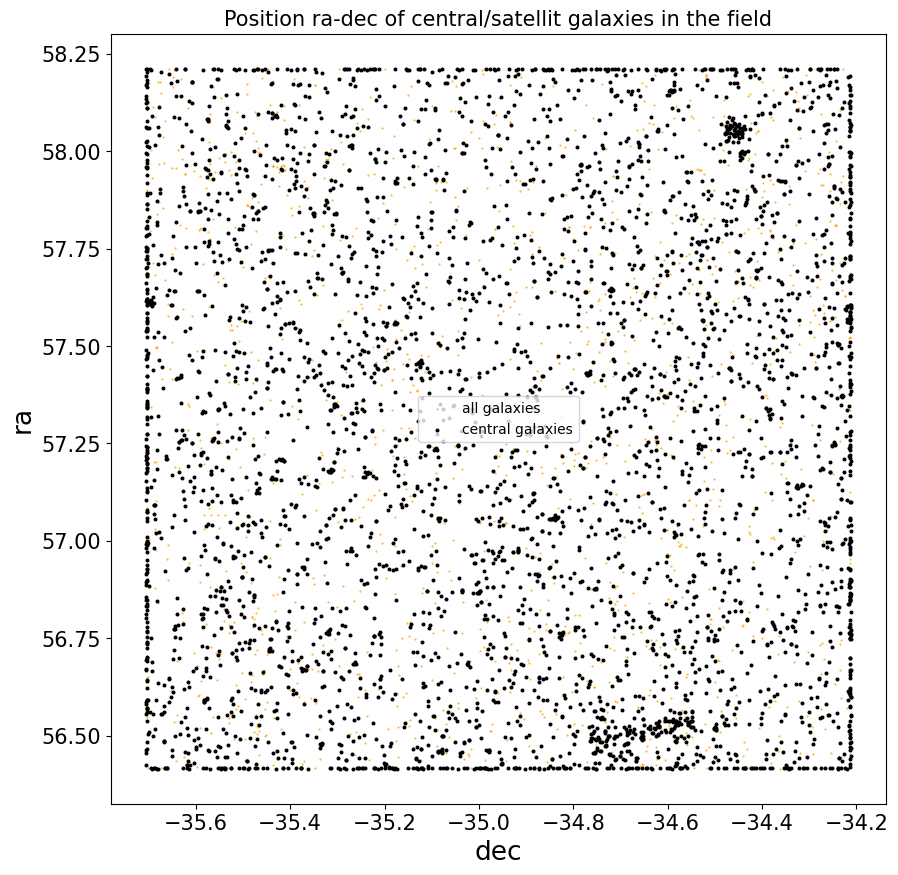

In [46]:
plt.figure(figsize=(10, 10))

plt.scatter(dec_truth_1_0_all_i_mag_24, ra_truth_1_0_all_i_mag_24, s=0.2, label='all galaxies', color='orange')
plt.scatter(dec_truth_1_0_central_i_mag_24, ra_truth_1_0_central_i_mag_24, s=3.5, label='central galaxies', color='black')
plt.legend()
plt.xlabel('dec', fontsize=19)
plt.ylabel('ra', fontsize=19)
plt.title('Position ra-dec of central/satellit galaxies in the field', fontsize=15)
plt.savefig('(1-0)_system_study_for_galaxy_out_clusters_plot/Position ra-dec of central_satellit galaxies in the field')
plt.show()

## (1-1) systems for galaxies in the field :

In [47]:
#selection indice des galaxies présentes dans les systèmes 1-1 :

system_1_1_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 1)))
system_1_1_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 1) & (n_object == 1)))

ind_truth_all_1_1=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]][system_1_1_mask_all]['row_index']
ind_truth_central_1_1=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]][system_1_1_mask_central]['row_index']

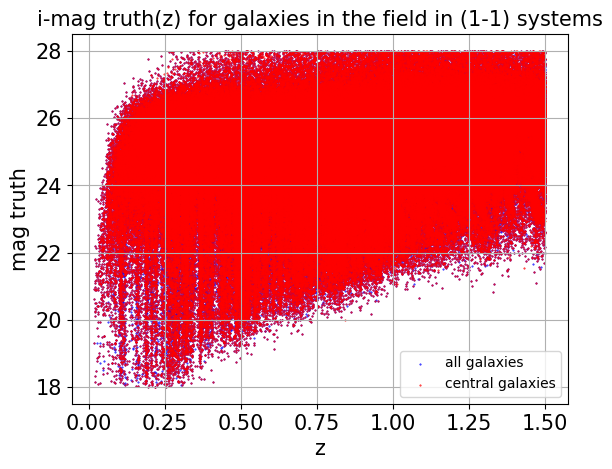

In [48]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_1_1], truth_data['mag_i'][ind_truth_all_1_1], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_1_1], truth_data['mag_i'][ind_truth_central_1_1], s=0.2, label='central galaxies', color='red')
plt.xlabel('z', fontsize=15)
plt.ylabel('mag truth', fontsize=15)
plt.title('i-mag truth(z) for galaxies in the field in (1-1) systems')
plt.legend()
plt.grid()
plt.savefig('(1-1)_system_study_for_galaxy_out_clusters_plot/i-mag truth(z) for galaxies in the field in (1-1) systems')
plt.show()

In [49]:
print("% of (1-1) systems in the different clusters =", (len(ind_truth_all_1_1)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]))*100)

% of (1-1) systems in the different clusters = 23.39549075016088


In [50]:
system_1_1_mask_all_obj= np.in1d(results[object_mask]['group_id'], np.flatnonzero((n_truth_2cut_all == 1) & (n_object == 1)))

ind_object_1_1=results[object_mask][system_1_1_mask_all_obj]['row_index']

In [51]:
truth_i_mag=truth_data['mag_i'][ind_truth_all_1_1]

object_i_mag= object_data['mag_i_cModel'][ind_object_1_1]

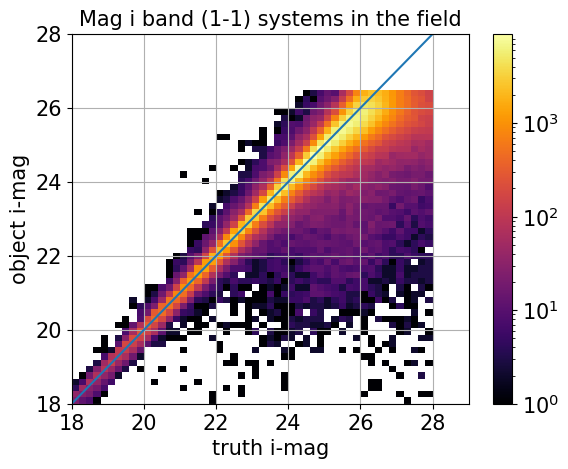

In [52]:
plt.title("Mag i band (1-1) systems in the field")
plt.hist2d(truth_i_mag, object_i_mag, bins=50, norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.grid()
plt.xlim(18,29)
plt.ylim(18,28)
plt.xlabel("truth i-mag", fontsize=15)
plt.ylabel("object i-mag", fontsize=15)
plt.savefig('(1-1)_system_study_for_galaxy_out_clusters_plot/Mag i band (1-1) systems in the field')
plt.show()

## (2-1) systems for galaxies in the field :

In [53]:
#selection indice des galaxies présentes dans les systèmes 2-1 :

system_2_1_mask_all= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]['group_id'],
                             np.flatnonzero((n_truth_2cut_all == 2) & (n_object == 1)))
system_2_1_mask_central= np.in1d(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]]['group_id'],
                                 np.flatnonzero((n_truth_2cut_central == 2) & (n_object == 1)))

ind_truth_all_2_1=results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]][system_2_1_mask_all]['row_index']
ind_truth_central_2_1=results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]<halo_mass_cut_13[0]))[0]][system_2_1_mask_central]['row_index']

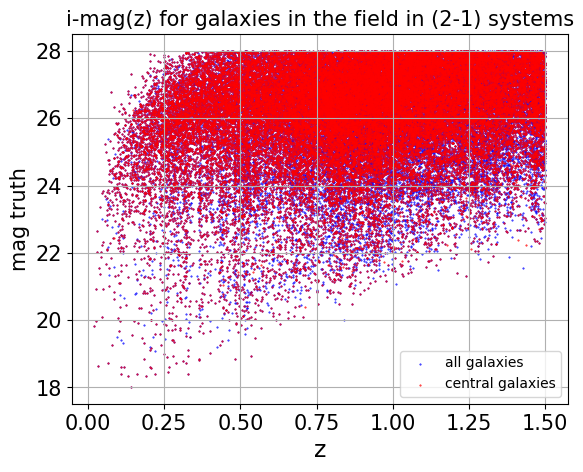

In [54]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_truth_all_2_1], truth_data['mag_i'][ind_truth_all_2_1], s=0.2, label='all galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_truth_central_2_1], truth_data['mag_i'][ind_truth_central_2_1], s=0.2, label='central galaxies', color='red')
plt.xlabel('z', fontsize=17)
plt.ylabel('mag truth', fontsize=15)
plt.title('i-mag(z) for galaxies in the field in (2-1) systems')
plt.legend()
plt.grid()
plt.savefig('2-1_system_studies_field_plot/i-mag(z) for galaxies in the field in (2-1) systems')
plt.show()

In [55]:
print("% of (2-1) systems in the different clusters =", (len(ind_truth_all_2_1)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]))*100)

print("petit pourcentage mais normal puisque l'on selectionne que les galaxies appartenants aux clusters en ne prenant pas en compte des galaxies en background avec lesquelles il y a une           probabilité plus forte d'y avoir blending. (cf notebook study_with_background_galaxies)")

% of (2-1) systems in the different clusters = 2.8499463896641464
petit pourcentage mais normal puisque l'on selectionne que les galaxies appartenants aux clusters en ne prenant pas en compte des galaxies en background avec lesquelles il y a une           probabilité plus forte d'y avoir blending. (cf notebook study_with_background_galaxies)


### (2-1) system with background galaxies (z<1,5) for the field :

In [56]:
n_truth_z_max_cut_all = np.bincount(results[truth_mask][np.where(truth_data['redshift'][ind_galax]<z_max_cut)[0]]['group_id'],
                                    minlength=n_groups)

#selection indice de TOUTES les galaxies (pas forcément faisant parti field mais avec z<1,5) présentes dans les systèmes 2-1 :

system_2_1_mask_all_back= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut))[0]]['group_id'], np.flatnonzero((n_truth_z_max_cut_all == 2) & (n_object == 1)))

ind_truth_all_2_1_back=results[truth_mask][np.where((truth_data_z<z_max_cut))[0]][system_2_1_mask_all_back]['row_index'].copy()

In [57]:
#selection of systems with at least one of the galaxies that are not belonging to a cluster belonging to a cluster :

ind_truth_all_2_1_back_good=np.zeros(len(ind_truth_all_2_1_back))
i=0
for i in  tqdm(np.arange(0,len(ind_truth_all_2_1_back), 2)) :
    i+=2
    if ((truth_data['halo_mass'][ind_truth_all_2_1_back[i-2]] < halo_mass_cut_13[0]) or (truth_data['halo_mass'][ind_truth_all_2_1_back[i-1]] < halo_mass_cut_13[0])) :
        ind_truth_all_2_1_back_good[i-2]=ind_truth_all_2_1_back[i-2]
        ind_truth_all_2_1_back_good[i-1]=ind_truth_all_2_1_back[i-1]

  0%|          | 0/29723 [00:00<?, ?it/s]

In [58]:
ind_truth_all_2_1_back_good=ind_truth_all_2_1_back_good[np.where(ind_truth_all_2_1_back_good != 0)[0]].copy()

len(ind_truth_all_2_1_back_good)

59236

In [59]:
print("% of (2-1) systems (with at least 1 of the 2 galaxies of the system belonging to the field) in all clusters with z<1,5 =", (len(ind_truth_all_2_1_back_good)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]))*100)

% of (2-1) systems (with at least 1 of the 2 galaxies of the system belonging to the field) in all clusters with z<1,5 = 2.9527306876927515


# (2-1) system with ALL background galaxies :

In [60]:
n_truth_all = np.bincount(results[truth_mask][ind_galax]['group_id'], minlength=n_groups)

#selection indice de TOUTES les galaxies (pas forcément faisant parti d'un amas mais de z<1,5) présentes dans les systèmes 2-1 :

system_2_1_mask_all_back3= np.in1d(results[truth_mask]['group_id'], np.flatnonzero((n_truth_all == 2) & (n_object == 1)))

ind_truth_all_2_1_back3=results[truth_mask][system_2_1_mask_all_back3]['row_index'].copy()

In [61]:
#selection of systems with at least one of the 2 galaxies belonging to the field :

ind_truth_all_2_1_back_good3=np.zeros(len(ind_truth_all_2_1_back3))

for i in tqdm(np.arange(0,len(ind_truth_all_2_1_back3), 2)) :
    
    i+=2
    
    if ((truth_data['halo_mass'][ind_truth_all_2_1_back3[i-2]] < halo_mass_cut_13[0]) & (truth_data['redshift'][ind_truth_all_2_1_back3[i-2]] < 1.5)) :
        
        ind_truth_all_2_1_back_good3[i-2]=ind_truth_all_2_1_back3[i-2]
        ind_truth_all_2_1_back_good3[i-1]=ind_truth_all_2_1_back3[i-1]
        
    if ((truth_data['halo_mass'][ind_truth_all_2_1_back3[i-1]] < halo_mass_cut_13[0]) & (truth_data['redshift'][ind_truth_all_2_1_back3[i-1]] < 1.5)) :
        
        ind_truth_all_2_1_back_good3[i-2]=ind_truth_all_2_1_back3[i-2]
        ind_truth_all_2_1_back_good3[i-1]=ind_truth_all_2_1_back3[i-1]

  0%|          | 0/54858 [00:00<?, ?it/s]

In [62]:
ind_truth_all_2_1_back_good3=ind_truth_all_2_1_back_good3[np.where(ind_truth_all_2_1_back_good3 != 0)[0]].copy()

len(ind_truth_all_2_1_back_good3)

97228

In [63]:
print("% of (2-1) systems (with one of the two galaxies not belonging to a cluster and with z<1,5) in the different clusters =", (len(ind_truth_all_2_1_back_good3)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass<halo_mass_cut_13[0]))[0]]))*100)

% of (2-1) systems (with one of the two galaxies not belonging to a cluster and with z<1,5) in the different clusters = 4.84651393245646


Très peu de blending pour les galaxies du champ.

In [64]:
ind_truth_all_2_1_back_good3= results[truth_mask][np.in1d(results[truth_mask]['row_index'],ind_truth_all_2_1_back_good3)]['row_index'].copy() #pour repasser dans type dictio

In [65]:
results[truth_mask][np.in1d(results[truth_mask]['row_index'],ind_truth_all_2_1_back_good3)]

row_index,catalog_key,group_id
int64,str6,int64
803522,galaxy,27
2329731,galaxy,27
890764,galaxy,72
1036433,galaxy,72
1959376,galaxy,102
2799277,galaxy,102
1808633,galaxy,111
2825533,galaxy,111
1817369,galaxy,113


In [66]:
brightest_galaxies= [] #np.zeros(len(ind_truth_all_2_1_back3_good3))
faintest_galaxies= [] #np.zeros(len(ind_truth_all_2_1_back3_good3))

for i in tqdm(np.arange(0, len(ind_truth_all_2_1_back_good3), 2)):
    i+=2
    if (truth_data['mag_i'][ind_truth_all_2_1_back_good3[i-2]] < truth_data['mag_i'][ind_truth_all_2_1_back_good3[i-1]]) :
        brightest_galaxies.append(ind_truth_all_2_1_back_good3[i-2])
        faintest_galaxies.append(ind_truth_all_2_1_back_good3[i-1])
        
    if (truth_data['mag_i'][ind_truth_all_2_1_back_good3[i-2]] > truth_data['mag_i'][ind_truth_all_2_1_back_good3[i-1]]) :
        brightest_galaxies.append(ind_truth_all_2_1_back_good3[i-1])
        faintest_galaxies.append(ind_truth_all_2_1_back_good3[i-2])

  0%|          | 0/48614 [00:00<?, ?it/s]

In [67]:
brightest_galaxies=np.array(brightest_galaxies)
ind_brightest_galaxies=results[truth_mask][np.in1d(results[truth_mask]['row_index'], brightest_galaxies)]['row_index']

In [68]:
faintest_galaxies=np.array(faintest_galaxies)
ind_faintest_galaxies=results[truth_mask][np.in1d(results[truth_mask]['row_index'], faintest_galaxies)]['row_index']

# I-mag studies :

In [69]:
# object selection :

ind_object_2_1_all_good= results[object_mask][np.in1d(results[object_mask]['group_id'], results[truth_mask][np.in1d(results[truth_mask]['row_index'], brightest_galaxies)]['group_id'])]['row_index']

## Brightest galaxies :

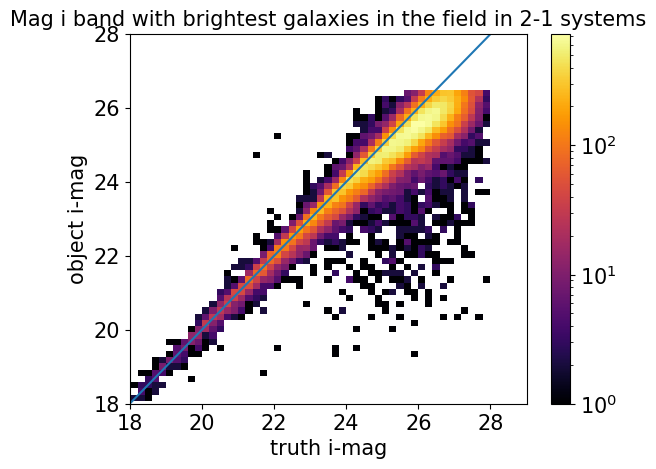

In [70]:
hist2d_mag=plt.hist2d(truth_data['mag_i'][ind_brightest_galaxies],
                      object_data['mag_i_cModel'][ind_object_2_1_all_good], 
                      bins=50, 
                      norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("truth i-mag", fontsize=15)
plt.ylabel("object i-mag", fontsize=15)
plt.xlim(18,29)
plt.ylim(18,28)
plt.title("Mag i band with brightest galaxies in the field in 2-1 systems")
plt.savefig('2-1_system_blending_studies_with_background_field/Mag i band with brightest galaxies in the field in 2-1 systems')
plt.show()

Pour les magnitude apparente les plus fortes, biais plus fort que pour les galaxies des clusters

## Faintest galaxies :

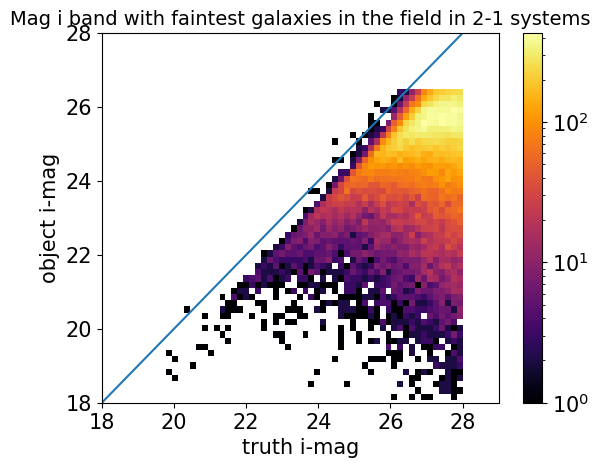

In [71]:
hist2d_mag=plt.hist2d(truth_data['mag_i'][ind_faintest_galaxies],
                      object_data['mag_i_cModel'][ind_object_2_1_all_good], 
                      bins=50, 
                      norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("truth i-mag", fontsize=15)
plt.ylabel("object i-mag", fontsize=15)
plt.xlim(18,29)
plt.ylim(18,28)
plt.title("Mag i band with faintest galaxies in the field in 2-1 systems", fontsize=14)
plt.savefig('2-1_system_blending_studies_with_background_field/Mag i band with faintest galaxies in the field in 2-1 systems')
plt.show()

## Redshift distrib :

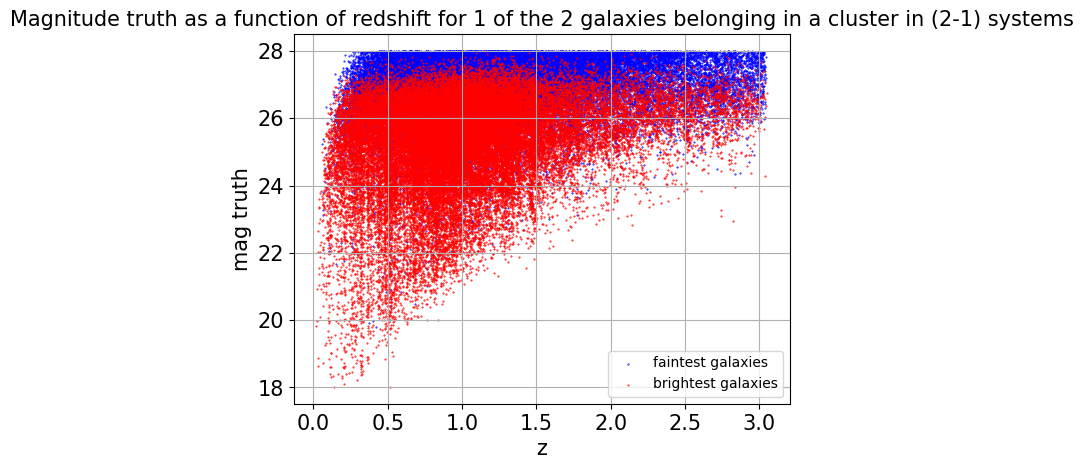

In [72]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_faintest_galaxies], truth_data['mag_i'][ind_faintest_galaxies], s=0.2, label='faintest galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_brightest_galaxies], truth_data['mag_i'][ind_brightest_galaxies], s=0.2, label='brightest galaxies', color='red')
plt.xlabel('z', fontsize=15)
plt.ylabel('mag truth', fontsize=15)
plt.title('Magnitude truth as a function of redshift for 1 of the 2 galaxies belonging in a cluster in (2-1) systems')
plt.legend()
plt.grid()
plt.savefig('2-1_system_blending_studies_with_background_field/Magnitude truth as a function of redshift for 1 of the 2 galaxies belonging in a cluster in (2-1) systems')
plt.show()

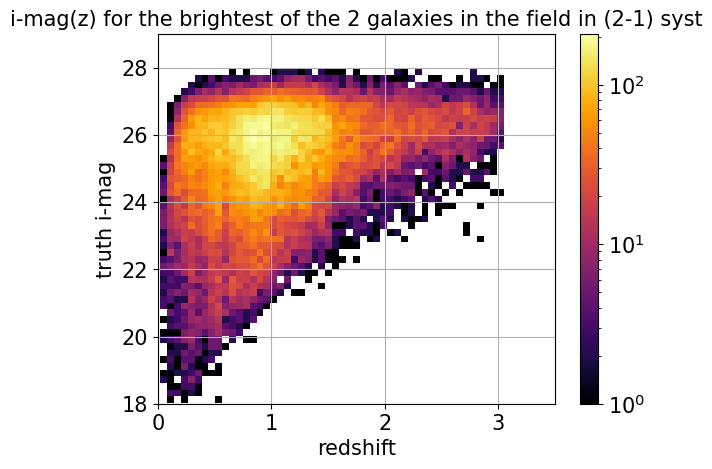

In [73]:
hist2d_mag=plt.hist2d(truth_data['redshift'][ind_brightest_galaxies],
                      truth_data['mag_i'][ind_brightest_galaxies], 
                      bins=50, 
                      norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("redshift", fontsize=15)
plt.ylabel("truth i-mag", fontsize=15)
plt.ylim(18,29)
plt.xlim(0,3.5)
plt.grid()
plt.title("i-mag(z) for the brightest of the 2 galaxies in the field in (2-1) syst")
plt.savefig('2-1_system_blending_studies_with_background_field/i-mag(z) for the brightest of the 2 galaxies belonging in the field in (2-1) systems')
plt.show()

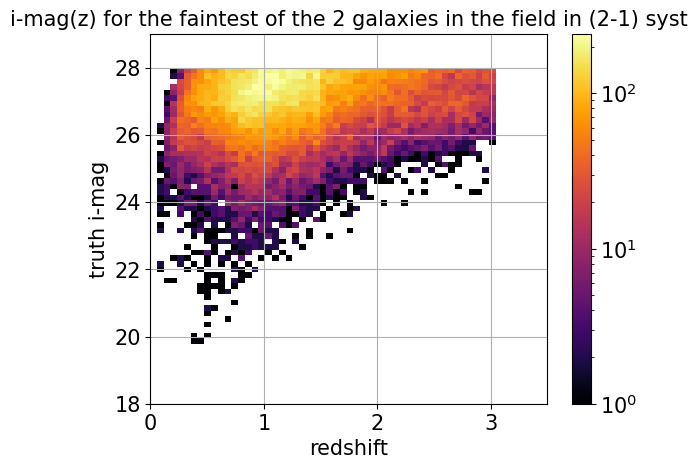

In [74]:
hist2d_mag=plt.hist2d(truth_data['redshift'][ind_faintest_galaxies],
                      truth_data['mag_i'][ind_faintest_galaxies], 
                      bins=50, 
                      norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("redshift", fontsize=15)
plt.ylabel("truth i-mag", fontsize=15)
plt.xlim(0,3.5)
plt.ylim(18,29)
plt.grid()
plt.title("i-mag(z) for the faintest of the 2 galaxies in the field in (2-1) syst")
plt.savefig('2-1_system_blending_studies_with_background_field/i-mag(z) for the faintest of the 2 galaxies belonging in the field in (2-1) systems')
plt.show()

## Halo_mass distrib :

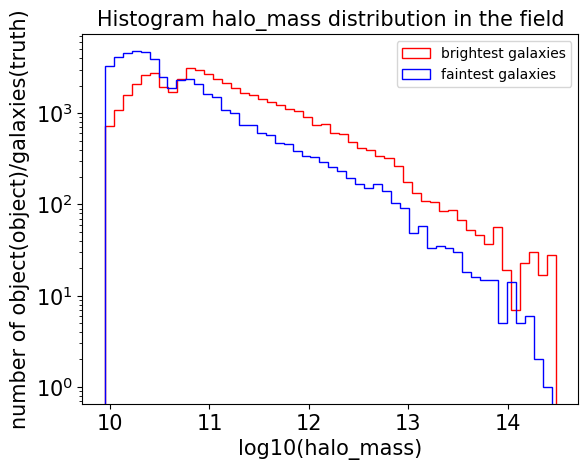

In [75]:
plt.figure()
plt.hist(np.log10(truth_data['halo_mass'][ind_brightest_galaxies]), bins=50, 
                            histtype='step', label='brightest galaxies', log=True, color='red')
plt.hist(np.log10(truth_data['halo_mass'][ind_faintest_galaxies]), bins=50,
                            histtype='step', label='faintest galaxies', log=True, color='blue')
plt.legend()
plt.xlabel('log10(halo_mass)', fontsize=15)
plt.ylabel('number of object(object)/galaxies(truth)', fontsize=15)
plt.xticks()
plt.yticks()
plt.title('Histogram halo_mass distribution in the field')
plt.savefig('2-1_system_blending_studies_with_background_field/Histo halo_mass brightest faintest in the field')
plt.show()